In [1]:
# 采用类似one-hot的方式编码空值特征
## 2. 对于数值型特征; 空值特征补值（未定），对于存在缺失值的空值特征，增加一个新特征-isNull
## 3. 对于类别特征：对极其稀疏的一些特征，可能要做合并
## 4. 对于类别特征，one-hot编码

In [2]:
## 导入相关库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import pickle

In [3]:
## 查看内存
def checkMemory(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")

In [4]:
## 返回数值类型
def fileter_numeric_cols(data):
    numeric_cols = set()
    numric_cols_cnt = 0

    for col in data.columns:
        col_type = str(data[col].dtypes)
        #print(col_type, type(col_type))
        if col_type[:3] == 'int' or col_type[:5] == 'float' or col_type[:6] == 'double':
            numeric_cols.add(col_type)
            numric_cols_cnt  += 1

    return list(numeric_cols)

In [5]:
## 改变数值类型特征的存储格式，降低内存
def reduce_mem_usage(df, numerics, verbose=True):
    #numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, \
                                                                    100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
## 读取数据
train_identity = pd.read_csv('data/train_identity.csv')
train_transaction = pd.read_csv('data/train_transaction.csv')
test_identity = pd.read_csv('data/test_identity.csv')
test_transaction = pd.read_csv('data/test_transaction.csv')

In [9]:
train_identity = reduce_mem_usage(train_identity, ['int64','float64'])
test_identity = reduce_mem_usage(test_identity,['int64','float64'])
train_identity = reduce_mem_usage(train_transaction, ['int64','float64'])
test_identity = reduce_mem_usage(test_transaction,['int64','float64'])

Mem. usage decreased to 25.86 Mb (0.0% reduction)
Mem. usage decreased to 25.44 Mb (0.0% reduction)
Mem. usage decreased to 542.35 Mb (69.4% reduction)
Mem. usage decreased to 472.59 Mb (68.9% reduction)


In [10]:
SPLIT_POINT = 590540

df_all = pd.concat((train_transaction, test_transaction), axis=0).reset_index()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
df_all.shape

(1097231, 395)

In [11]:
tmp = df_all

In [13]:
## 处理特征
### 1. 判断哪些columns存在空值，并存入features

def judgeNullFeatures(df):
    feature_has_null = df.isnull().sum()
    feature_has_null = feature_has_null.drop(feature_has_null[feature_has_null == 0].index)
    features = [index for index in feature_has_null.index]
    
    return feature_has_null, features

transaction_feature_has_null, transaction_null_features = judgeNullFeatures(tmp)

In [14]:
### 2. 依次对于每个存在空值的‘数值型’特征
#### a. 增加一个新特征{feature}_isNull；
#### b.根据{feature}值的是否为空值，在{feature}_isNull中填入0或1

def addIsNullFeature(df):
    return df.where(df.isnull(),0).fillna(1)

print('处理前特征数为',tmp.shape[1])
for feature in transaction_null_features:
    if tmp[feature].dtypes != object:
        tmp[feature+'_isNull'] = addIsNullFeature(tmp[feature]).astype(np.int8)
print('处理后特征数为',tmp.shape[1])

处理前特征数为 395
处理后特征数为 771


In [15]:
### 3. 数值型的特征，其空值填为最小值-1
def fill_numbers(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")

    for col in props.columns:
        if props[col].dtype != object:  
            
            # Print current column type
            #print("******************************")
            #print("Column: ",col)
            #print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all():  
                props[col].fillna(mn-1,inplace=True)  

    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props

tmp = fill_numbers(tmp)

Memory usage of properties dataframe is : 1433.5694789886475  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  1433.5694789886475  MB
This is  100.0 % of the initial size


In [16]:
### 4. 处理P_email及R_email两个字段，将出现频率小的合并为others

def mergeEmailFeature(df, email_feature, top_email_num=8):
    top_email_cols = (df[email_feature].value_counts(dropna=False) / \
                      df.shape[0] * 100)[:top_email_num]

    print('top {0} email domain rank {1} %'.format(top_email_num, top_email_cols.sum()))
    
    df[email_feature] = df[email_feature].apply(lambda x: \
                                                        x if x in top_email_cols.index else 'others')
    print(top_email_cols)
    
    
mergeEmailFeature(tmp,'P_emaildomain', top_email_num=8)
mergeEmailFeature(tmp,'R_emaildomain', top_email_num=6)

top 8 email domain rank 92.78565771473829 %
gmail.com        39.718437
yahoo.com        16.658662
NaN              14.914635
hotmail.com       7.805922
anonymous.com     6.476485
aol.com           4.769916
comcast.net       1.319139
icloud.com        1.122462
Name: P_emaildomain, dtype: float64
top 6 email domain rank 97.00865177888703 %
NaN              75.104513
gmail.com        10.835002
hotmail.com       4.845470
anonymous.com     3.613095
yahoo.com         1.950820
aol.com           0.659752
Name: R_emaildomain, dtype: float64


In [17]:
def fill_dummy_category(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    print("before, data shape {0}".format(props.shape))
    need_drop = []
    need_add = pd.DataFrame()
    for col in props.columns:
        if props[col].dtype == object:  # Exclude strings
            
            need_drop.append(col)
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            #print("dtype before: ",props[col].dtype)
            print("取值种类: {0}".format(len(props[col].value_counts(dropna=False).index)))
            
            dummy = pd.get_dummies(props[col], dummy_na=True, prefix='%s_'%col)
            
            need_add = pd.concat((need_add, dummy), axis=1)


    props = props.drop(need_drop, axis=1)
    props = pd.concat((props, need_add), axis=1)
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    print("after, data shape {0}".format(props.shape))
    
    return props
tmp = fill_dummy_category(tmp)

Memory usage of properties dataframe is : 1433.5694789886475  MB
before, data shape (1097231, 771)
******************************
Column:  M1
取值种类: 3
******************************
Column:  M2
取值种类: 3
******************************
Column:  M3
取值种类: 3
******************************
Column:  M4
取值种类: 4
******************************
Column:  M5
取值种类: 3
******************************
Column:  M6
取值种类: 3
******************************
Column:  M7
取值种类: 3
******************************
Column:  M8
取值种类: 3
******************************
Column:  M9
取值种类: 3
******************************
Column:  P_emaildomain
取值种类: 9
******************************
Column:  ProductCD
取值种类: 5
******************************
Column:  R_emaildomain
取值种类: 7
******************************
Column:  card4
取值种类: 5
******************************
Column:  card6
取值种类: 5
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  1379.1566257476807  MB
This is  96.20437976404507 % of the initial size
after, data shape (109723

In [18]:
tmp.shape

(1097231, 817)

In [17]:
pd.set_option('display.max_columns', None)
tmp.head()

,index,C1,C10,C11,C12,C13,C14,C2,C3,C4,C5,C6,C7,C8,C9,D1,D10,D11,D12,D13,D14,D15,D2,D3,D4,D5,D6,D7,D8,D9,TransactionAmt,TransactionDT,TransactionID,V1,V10,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V11,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V12,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V13,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V14,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V15,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V16,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V17,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V18,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V19,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V2,V20,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V21,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V22,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V23,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V24,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V25,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V26,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V27,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V28,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V29,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V3,V30,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V31,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V32,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V33,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,V34,V35,V36,V37,V38,V39,V4,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V5,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V6,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V7,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V8,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V9,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,addr1,addr2,card1,card2,card3,card5,dist1,dist2,isFraud,C1_isNull,C10_isNull,C11_isNull,C12_isNull,C13_isNull,C14_isNull,C2_isNull,C3_isNull,C4_isNull,C5_isNull,C6_isNull,C7_isNull,C8_isNull,C9_isNull,D1_isNull,D10_isNull,D11_isNull,D12_isNull,D13_isNull,D14_isNull,D15_isNull,D2_isNull,D3_isNull,D4_isNull,D5_isNull,D6_isNull,D7_isNull,D8_isNull,D9_isNull,V1_isNull,V10_isNull,V100_isNull,V101_isNull,V102_isNull,V103_isNull,V104_isNull,V105_isNull,V106_isNull,V107_isNull,V108_isNull,V109_isNull,V11_isNull,V110_isNull,V111_isNull,V112_isNull,V113_isNull,V114_isNull,V115_isNull,V116_isNull,V117_isNull,V118_isNull,V119_isNull,V12_isNull,V120_isNull,V121_isNull,V122_isNull,V123_isNull,V124_isNull,V125_isNull,V126_isNull,V127_isNull,V128_isNull,V129_isNull,V13_isNull,V130_isNull,V131_isNull,V132_isNull,V133_isNull,V134_isNull,V135_isNull,V136_isNull,V137_isNull,V138_isNull,V139_isNull,V14_isNull,V140_isNull,V141_isNull,V142_isNull,V143_isNull,V144_isNull,V145_isNull,V146_isNull,V147_isNull,V148_isNull,V149_isNull,V15_isNull,V150_isNull,V151_isNull,V152_isNull,V153_isNull,V154_isNull,V155_isNull,V156_isNull,V157_isNull,V158_isNull,V159_isNull,V16_isNull,V160_isNull,V161_isNull,V162_isNull,V163_isNull,V164_isNull,V165_isNull,V166_isNull,V167_isNull,V168_isNull,V169_isNull,V17_isNull,V170_isNull,V171_isNull,V172_isNull,V173_isNull,V174_isNull,V175_isNull,V176_isNull,V177_isNull,V178_isNull,V179_isNull,V18_isNull,V180_isNull,V181_isNull,V182_isNull,V183_isNull,V184_isNull,V185_isNull,V186_isNull,V187_isNull,V188_isNull,V189_isNull,V19_isNull,V190_isNull,V191_isNull,V192_isNull,V193_isNull,V194_isNull,V195_isNull,V196_isNull,V197_isNull,V198_isNull,V199_isNull,V2_isNull,V20_isNull,V200_isNull,V201_isNull,V202_isNull,V203_isNull,V204_isNull,V205_isNull,V206_isNull,V207_isNull,V208_isNull,V209_isNull,V21_isNull,V210_isNull,V211_isNull,V212_isNull,V213_isNull,V214_isNull,V215_isNull,V216_isNull,V217_isNull,V218_isNull,V219_isNull,V22_isNull,V220_isNull,V221_isNull,V222_isNull,V223_isNull,V224_isNull,V225_isNull,V226_isNull,V227_isNull,V228_isNull,V229_isNull,V23_isNull,V230_isNull,V231_isNull,V232_isNull,V233_isNull,V234_isNull,V235_isNull,V236_isNull,V237_isNull,V238_isNull,V239_isNull,V24_isNull,V240_isNull,V241_isNull,V242_isNull,V243_is

In [19]:
tmp = reduce_mem_usage(tmp, ['int64', 'float64'])

Mem. usage decreased to 1368.69 Mb (0.8% reduction)


In [20]:
df_train = tmp[:SPLIT_POINT]
df_test  = tmp[SPLIT_POINT:]

In [21]:
with open('df_merged_train.pkl', 'wb') as f:
    pickle.dump(df_train, f)
    print("df_train dump finished")
    
with open('df_merged_test.pkl', 'wb') as f:
    pickle.dump(df_test, f)    
    print("df_test dump finished")

df_train dump finished
df_test dump finished


In [22]:
import xgboost as xgb

clf = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    missing=-999,
    random_state=2019
#    tree_method='gpu_hist'  # THE MAGICAL PARAMETER
)


In [23]:
%time clf.fit(df_train.drop(['TransactionID', 'index', 'isFraud'], axis=1), df_train['isFraud'])

Wall time: 8h 5min 51s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=-999, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=2019,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

In [24]:
sample_submission = pd.read_csv('Data/sample_submission.csv')
sample_submission['isFraud'] = clf.predict_proba(df_test.drop(['TransactionID', 'index', 'isFraud'], axis=1))[:,1]
sample_submission.to_csv('simple_xgboost-scaler-0918V1-cmh.csv', index=False, columns=['TransactionID', 'isFraud'])

In [ ]:
# Finally result = 0.9354 
# rank = 3433/5389

In [44]:
from xgboost import plot_importance

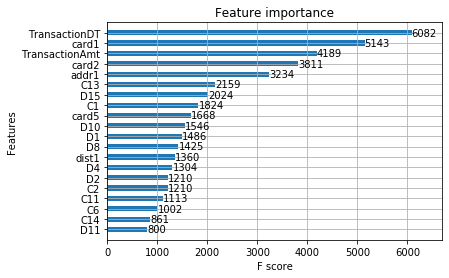

In [50]:
plot_importance(clf,height=0.5, max_num_features=20,importance_type='weight')
plt.show()

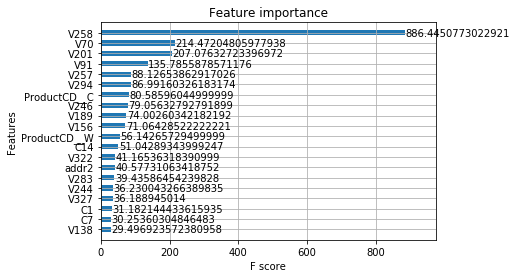

In [51]:
plot_importance(clf,height=0.5, max_num_features=20,importance_type='gain')
plt.show()

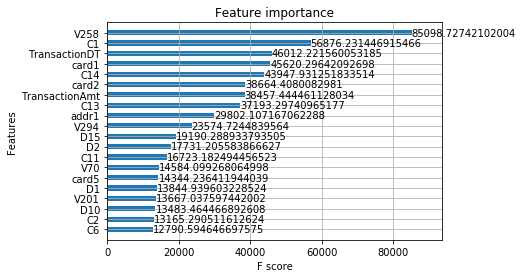

In [55]:
plot_importance(clf,height=0.5, max_num_features=20,importance_type='total_gain')
plt.show()

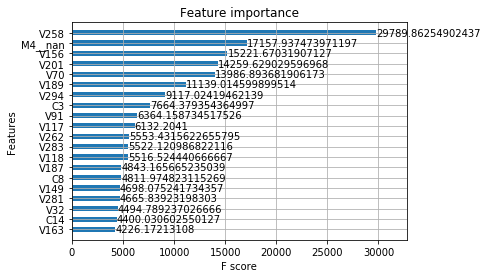

In [53]:
plot_importance(clf,height=0.5, max_num_features=20,importance_type='cover')
plt.show()

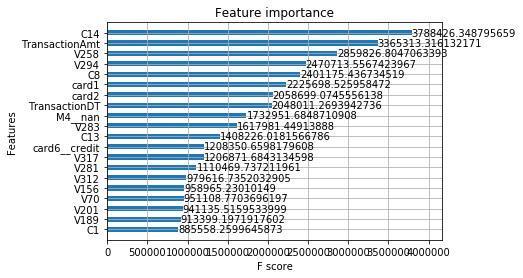

In [54]:
plot_importance(clf,height=0.5, max_num_features=20,importance_type='total_cover')
plt.show()

In [56]:
## 保存XGBoost模型
clf.get_booster().save_model('xgb.model')

In [57]:
## 载入XGBoost模型
tar = xgb.Booster(model_file='xgb.model')

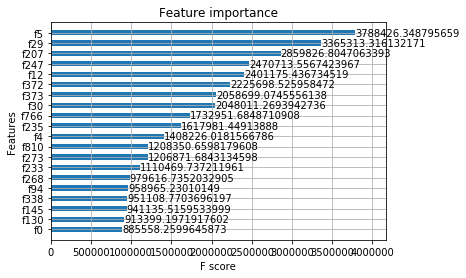

In [58]:
plot_importance(tar,height=0.5, max_num_features=20,importance_type='total_cover')
plt.show()